# Using metrics to assess the performance of your neural network
----

Hello everyone! In this tutorial, we are going to learn how to use various metrics in order to assess the performance of our neural networks. I have chosen to work on three cases:
* **Multi-Classification** 
>For this task, we are going to use the __*accuracy*__, __*confusion matrix*__ and __*average precision*__ and __*recall*__ in order to evaluate the performance of the our model.
* **Imbalanced Binary Classification**
>When we are dealing with an imbalanced dataset, the accuracy of a model is not a reliable metric. Thus, we will use the __*ROC-AUC*__ score, which seems to be a more appropriate metric for imbalanced problems.
* **Regression**
> To assess the performance of our regression model, we will be using the $\boldsymbol{R^2}$ score (coefficient of determination).

I believe these cases are diverse enough to help you in any machine learning project you will encounter further. 
If you would like me to add any extra metrics that are not encountered below, please let me know and I will do my best to add them later on. So, let's get started :)!

** TensorFlow version used - 1.5 **


## Import useful libraries and enable eager mode
----

In [1]:
# Suppress future warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import functions to generate toy classication problems
from sklearn.datasets import load_wine
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression

# Import numpy for data preprocessing
import numpy as np

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

# Import PCA for dimensionality reduction
from sklearn.decomposition import PCA

In [2]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution()

## Part I: Dataset for multi-classification
----

In [3]:
wine_data = load_wine()

In [4]:
print('Type of data in the wine_data dictionary: ', list(wine_data.keys()))

Type of data in the wine_data dictionary:  ['data', 'target', 'target_names', 'DESCR', 'feature_names']


In [5]:
print('Number of classes: ', len(np.unique(wine_data.target)))

Number of classes:  3


In [6]:
print('Distribution of our targets: ', np.unique(wine_data.target, return_counts=True)[1])

Distribution of our targets:  [59 71 48]


In [7]:
print('Number of features in the dataset: ', wine_data.data.shape[1])

Number of features in the dataset:  13


### Standardize features
----
The scale of each feature varies a lot as you can see in the cell below. In order to speed up the training, we will normalize each feature to have zero mean and unit standard deviation. This process is called standardization and it is very helpful in the convergence of the neural network. 

In [9]:
# Standardize dataset
wine_data.data = (wine_data.data - np.mean(wine_data.data, axis=0))/np.std(wine_data.data, axis=0)

In [11]:
print('Standard deviation of each feature after standardization: ', np.std(wine_data.data, axis=0))

Standard deviation of each feature after standardization:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


###  Data visualization. Use PCA to reduce the dimensionality to 2D.
----
We will use PCA, only for visualization purposes. We will be training our neural network using all 13 features. 

Let's have a look at how these 3 classes are represented in the 2D space.

In [12]:
X_pca = PCA(n_components=2, random_state=2018).fit_transform(wine_data.data)

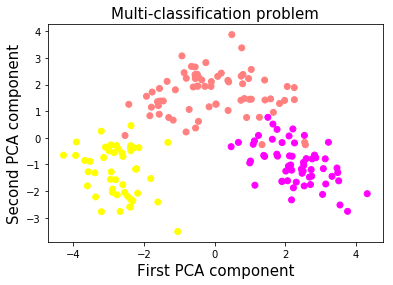

In [13]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=wine_data.target, cmap=plt.cm.spring)
plt.xlabel('First PCA component', fontsize=15)
plt.ylabel('Second PCA component', fontsize=15)
plt.title('Multi-classification problem', fontsize=15)
plt.show()

Okay, so it appears that the classes are easily separable. By the way, I actually tried using PCA before standardizing the features and the pink and yellow classes were overlapping. By standardizing the features before reducing the dimensionality we managed to obtain a much clear boundary between them. 

### Let's build a two-layers neural network using the TensorFlow Eager API
----

As you might have noticed, the most convenient way to build models using TensorFlow Eager is with classes. I think that using classes for your models makes it much easier to organize and adding new components to it. You simply define the layers that you're going to use during initialization and use them later on at the predict stage. It makes it easier to read the architecture of the model during the predict stage.

In [14]:
class two_layer_nn(tfe.Network):
    def __init__(self, output_size=3):
        # First hidden layer
        self.dense_1 = tf.layers.Dense(20, activation=tf.nn.relu)
        # Second hidden layer
        self.dense_2 = tf.layers.Dense(10, activation=tf.nn.relu)
        # Output layer. Unscaled log probabilities
        self.dense_out = tf.layers.Dense(output_size, activation=None)
    
    def predict(self, X):
        layer_1 = self.dense_1(X)
        layer_2 = self.dense_2(layer_1)
        logits = self.dense_out(layer_2)
        return logits

### Define loss function, optimizer and gradients function
----
** Important!** - When using the function 'tfe.implicit_gradients', it is important to run the forward pass of the model in the 'loss_fn' function. Otherwise, the function will not find any variable to compute the gradient for.

In [15]:
# Initialize model 
model = two_layer_nn(output_size=3)

In [16]:
# Define loss function
def loss_fn(model, X, y):
    logits = model.predict(X)
    return tf.losses.sparse_softmax_cross_entropy(y, logits)

In [17]:
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(5e-1)

In [18]:
# Function to compute the gradients of variables with respect to the loss function
grads_fn = tfe.implicit_gradients(loss_fn)

### Accuracy metric
----
To assess the performance of our model using the accuracy metric, we will be using the 'tfe.metrics.Accuracy' class. This metric is really useful when training a model in batches, as it computes the mean accuracy across batches each time it is called. As we train our model with the entire dataset at each step, we will be resetting this metric, as we do not want it to track the running mean.

In [19]:
accuracy = tfe.metrics.Accuracy()

In [20]:
# Create input features and targets dataset. Transfer data from numpy to tensors.
X = tf.constant(wine_data.data)
y = tf.constant(wine_data.target)

In [21]:
# Specify number of epochs
num_epochs = 5

# Create empty list to store the accuracy of each epoch
hist_accuracy = []

for i in range(num_epochs):
    # One step of gradient descent
    optimizer.apply_gradients(grads_fn(model, X, y))
    # Predict targets after taking a step of gradient descent
    logits = model.predict(X)
    preds = tf.argmax(logits, axis=1)
    # Compute the accuracy
    accuracy(preds, y)
    # Get the actual result and add it to our list
    hist_accuracy.append(accuracy.result())
    # Reset accuracy value (we don't want to track the running mean accuracy)
    accuracy.init_variables()
    

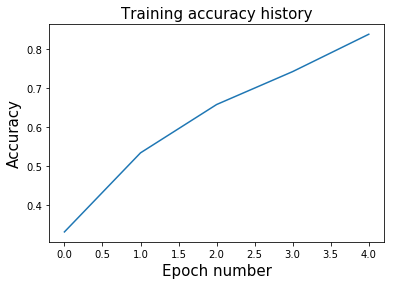

In [22]:
plt.plot(range(num_epochs), hist_accuracy);
plt.xlabel('Epoch number', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.title('Training accuracy history', fontsize=15);

### Confusion matrix
----
Visualizing the confusion matrix after you finished training the algorithm is a great way to give you global overview on the performance of your network. TensorFlow has a built-in function to compute the confusion matrix and fortunately it is compatible with eager mode. So let's visualize the confusion matrix of this dataset.

In [23]:
# Get the predictions on the entire dataset
logits = model.predict(X)
preds = tf.argmax(logits, axis=1)

In [24]:
# Print confusion matrix
conf_matrix = tf.confusion_matrix(y, preds, num_classes=3)
print('Confusion matrix: \n', conf_matrix.numpy())

Confusion matrix: 
 [[57  2  0]
 [ 8 63  0]
 [ 1 18 29]]


The diagonal matrix shows the true positives whilst the lower and upper bound of the matrix shows the false positives.

### Precision score
----
Most of the metrics available in TensorFlow belong to tf.metrics which unfortunately isn't compatible with eager mode at the moment. No worries though, the confusion matrix computed above makes it extremely easy to compute the mean average precision. I will implement a function below, which computes it automatically for you. You can also specify the weights of each class. For example, maybe the precision for class 2 is more important for you for some reason.

In [25]:
def precision(labels, predictions, weights=None):
    conf_matrix = tf.confusion_matrix(labels, predictions, num_classes=3)
    tp_and_fp = tf.reduce_sum(conf_matrix, axis=0)
    tp = tf.diag_part(conf_matrix)
    precision_scores = tp/(tp_and_fp)
    if weights:
        precision_score = tf.multiply(precision_scores, weights)/tf.reduce_sum(weights)
    else:
        precision_score = tf.reduce_mean(precision_scores)        
    return precision_score

In [26]:
precision_score = precision(y, preds, weights=None)
print('Average precision: ', precision_score.numpy())

Average precision:  0.8742241694048923


### Recall score
----
The average recall can be computed very similarly with the precision. Instead of summing the columns, we are going to sum the rows in order to get the total number of true positives and false negatives.

In [27]:
def recall(labels, predictions, weights=None):
    conf_matrix = tf.confusion_matrix(labels, predictions, num_classes=3)
    tp_and_fn = tf.reduce_sum(conf_matrix, axis=1)
    tp = tf.diag_part(conf_matrix)
    recall_scores = tp/(tp_and_fn)
    if weights:
        recall_score = tf.multiply(recall_scores, weights)/tf.reduce_sum(weights)
    else:
        recall_score = tf.reduce_mean(recall_scores)        
    return recall_score

In [28]:
recall_score = recall(y, preds, weights=None)
print('Average precision: ', recall_score.numpy())

Average precision:  0.8191974350812976


## Part II: Imbalanced binary classification

When you'll start working with real datasets, you will quickly come to notice that most of the problems are kinda imbalanced. For example, anomaly detection problems are severely imbalanced given the proportion of anomalous samples in comparison with the normal ones. In these cases, a more suitable metric to assess the performance of your network is the ROC-AUC score. So, let's build our imbalanced dataset and start working on it :)!

In [29]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_classes=2, n_clusters_per_class=1,
                           flip_y=0.01, class_sep=4, hypercube=False, 
                           shift=0.0, scale=1.0, random_state=2018)
# Reduce the number of samples with target 1
X = np.vstack([X[y==0], X[y==1][:15]])
y = np.hstack([y[y==0], y[y==1][:15]])

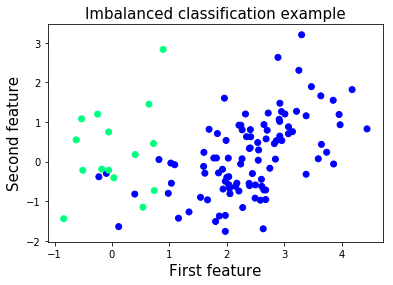

In [30]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.winter)
plt.xlabel('First feature', fontsize=15)
plt.ylabel('Second feature', fontsize=15)
plt.title('Imbalanced classification example', fontsize=15)
plt.show()

We will be using the same neural network architecture. We just have to initialize the model with num_classes=2, as we're working with a binary classification problem.

In [31]:
# Numpy arrays to tensors
X = tf.constant(X)
y = tf.constant(y)

# Initialize model 
model = two_layer_nn(output_size=2)

In [32]:
# Specify number of epochs
num_epochs = 5

for i in range(num_epochs):
    # One step of gradient descent
    optimizer.apply_gradients(grads_fn(model, X, y))
    # Predict targets after taking a step of gradient descent
    logits = model.predict(X)
    preds = tf.argmax(logits, axis=1)

## Part III: Dataset for regression
---
Our final dataset is created for a simple regression task. In the previous two problems, the output of the network represented the class the sample belongs to. Here the output of the network is continuous, a real number. 

Our input dataset consists only of one feature, to keep things simple and easy to visualize. The target y is a vector of real numbers.

Let's create our toy dataset :)!

In [45]:
X, y = make_regression(n_samples=100, n_features=1, n_informative=1, noise=30, 
                       random_state=2018)

### Visualize the input feature and target
----
To get a better glimpse on the problem we're working on, let's plot the input feature with regards to the target.

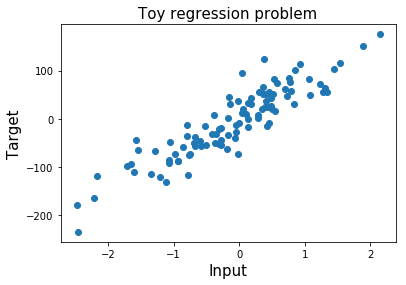

In [46]:
plt.scatter(X, y);
plt.xlabel('Input', fontsize=15);
plt.ylabel('Target', fontsize=15);
plt.title('Toy regression problem', fontsize=15);

### Neural network for regression task
----
We can re-use the two-layer neural network created above. As we only need to predict one real number, the output size of the network is 1.

In [47]:
# Numpy arrays to tensors
X = tf.constant(X)
y = tf.constant(y[:,None]) # change from row vector to column vector

# Initialize model 
model = two_layer_nn(output_size=1)

We have to redefine our loss function, as we cannot continue using the softmax cross-entropy loss. Instead, we will be using the mean squared error loss function. We will also define a new optimizer, with a smaller learning rate than the previous one. 

The function to compute the gradients of the variables with respect to the loss function stays the same.

In [48]:
# Define loss function
def loss_fn(model, X, y):
    preds = model.predict(X)
    return tf.losses.mean_squared_error(y, preds)

# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(1e-4)

# Function to compute the gradients of variables with respect to the loss function
grads_fn = tfe.implicit_gradients(loss_fn)

### Neural network training 
----
Feel free to play here with the number of epochs.

In [49]:
# Specify number of epochs
num_epochs = 300

for i in range(num_epochs):
    # One step of gradient descent
    optimizer.apply_gradients(grads_fn(model, X, y))

### Computing the $R^2$ score (coefficient of determination)
----
If you ever worked on a regression problem, you probably already heard about this score.

This metric computes the percentage of variability between the input features and the target, that is explained by our model. The range of values for the $R^2$ score is between 0 and 1. An $R^2$ score of 1 means that the model makes perfect predictions. An $R^2$ score of 0 is obtained by always predicting the mean of the targets y. 

It is possible to obtain negative values for $R^2$. In this case, it means that our model makes worse predictions than a model which always predicts the mean of the target variable. 

As this metric is not readily available in TensorFlow 1.5, when running in eager mode, I have created a small function for it, in the cell below.

In [50]:
# Compute the R2 score
def r_squared(labels, predictions):
    mean_labels = tf.reduce_mean(labels)
    total_sum_squares = tf.reduce_sum((labels-mean_labels)**2)
    residual_sum_squares = tf.reduce_sum((labels-predictions)**2)
    r2_score = 1 - residual_sum_squares/total_sum_squares
    return r2_score

preds = model.predict(X)
r2_score = r_squared(y, preds)
print('R2 score: ', r2_score.numpy())

R2 score:  0.8242846448887557


### Visualizing the line of best fit
----
To visualize the line of best fit of our neural network, we simply take the linear space between X_min and X_max. 

In [51]:
# Create datapoints between X_min and X_max to visualize the line of best fit
X_best_fit = np.arange(X.numpy().min(), X.numpy().max(), 0.001)[:,None]

In [52]:
# Predictions on X_best_fit
preds_best_fit = model.predict(X_best_fit)

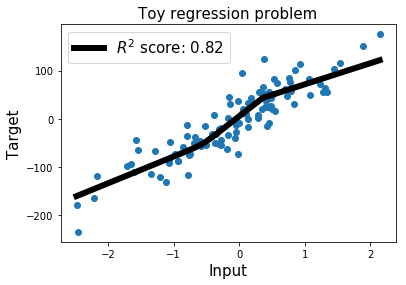

In [64]:
plt.scatter(X.numpy(), y.numpy()); # Original datapoints
plt.plot(X_best_fit, preds_best_fit.numpy(), color='k',
         linewidth=6, label='$R^2$ score: %.2f' %r2_score) # Our predictions
plt.xlabel('Input', fontsize=15);
plt.ylabel('Target', fontsize=15);
plt.title('Toy regression problem', fontsize=15);
plt.legend(fontsize=15);